# Behavorial Cloning Model

This is the model I made that uses a deep convolutional neural network to train a car to drive itself. The below python generator takes the data

## Reading In The Data

Below I read the driving_log.csv file into the program, and use a python generator to sort the data into features and data points

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


EPOCH = 10
batch_size = 32

def generator(data_set, batch_size):
    data_set_size = len(data_set)
    while 1:
        # Shuffle data_set to avoid overfitting
        shuffle(data_set)
        # For every batch of 32 data_set
        for batch_index in range(0, data_set_size, batch_size):
            # Capture all 32 data_set in this batch inside a variable
            batch_data_32 = data_set[batch_index:batch_index+batch_size]
            # Create lists to hold images and angles
            imgs = []
            angles = []
            # For every sample in the current batch (row in the csv file)
            for batch_row in batch_data_32:
                # For sample 0, 1, and 2 (row 1, 2, and 3 in csv)
                for cell_index in range(3):
                    # Save the file path from the csv file into a variable
                    path_from_root = batch_row[cell_index]
                    # Get the file name from the file path
                    file_name = path_from_root.split('/')[-1]
                    # Save the file path from model to image
                    model_to_img_path = 'data/IMG/' + file_name
                    # Save the image in a variable
                    img = cv2.imread(model_to_img_path)
                    # Add the image to the list of images
                    imgs.append(img)
                    # Get the data from the row's 'angle' column
                    angle = float(batch_row[3])
                    # If it is a left image
                    if cell_index == 1:
                        # Steer right
                        angle += 0.1
                    # If it is a right image
                    elif cell_index == 2:  
                        # Steer left
                        angle -= 0.1
                    # Add the new angle to the list
                    angles.append(angle)
            # Save the images into a numpy array
            x_train = np.array(imgs)
            # Save the angles into a numpy array
            y_train = np.array(angles)
            # Save the generator
            yield shuffle(x_train, y_train)



# Get rows from driving log csv file
rows = []
with open('data/driving_log.csv') as csvfile:
    # Read csv file into program
    data_file = csv.reader(csvfile)
    # For each row of the csv file, add it to the rows array
    for row in data_file:
        rows.append(row)

# Split the image dataset for validation
training_set, validation_set = train_test_split(rows, test_size=0.2)

# Prepare generators for training and validation sets
train_generator = generator(training_set, batch_size)
validation_generator = generator(validation_set, batch_size)

Using TensorFlow backend.


## Visualizing The Data

In the cell below I visualize an example of a center, left, and right image. These images are used to show the car what good driving looks like from each of the camera angles.

Left image shape: (160, 320, 3)
Center image shape: (160, 320, 3)
Right image shape: (160, 320, 3)
Training Set: 4112
Validation Set: 1029
Testing Set: The testing is all taken car of by the simulator

Sample center, left, and right images:


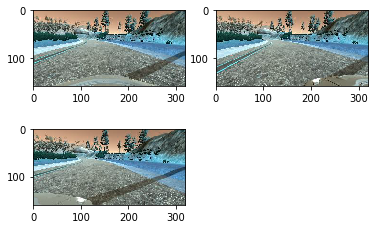

In [2]:
# Get file path from root
left_img_path = training_set[0][0]
center_img_path = training_set[0][1]
right_img_path = training_set[0][2]

# Get the file name from the file path
left_img_filename = left_img_path.split('/')[-1]
center_img_filename = center_img_path.split('/')[-1]
right_img_filename = right_img_path.split('/')[-1]

# save the file path from model to the image
left_img_current_path = 'data/IMG/' + left_img_filename
center_img_current_path = 'data/IMG/' + center_img_filename
right_img_current_path = 'data/IMG/' + right_img_filename

# save images in a variable
left_image = cv2.imread(left_img_current_path)
center_image = cv2.imread(center_img_current_path)
right_image = cv2.imread(right_img_current_path)

print("Left image shape: {}".format(left_image.shape))
print("Center image shape: {}".format(center_image.shape))
print("Right image shape: {}".format(right_image.shape))
print("Training Set: {}".format(len(training_set)))
print("Validation Set: {}".format(len(validation_set)))
print("Testing Set: The testing is all taken car of by the simulator\n")

fig = plt.figure()
print("Sample center, left, and right images:")
fig.add_subplot(2,2,1)
plt.imshow(left_image.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(center_image.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(right_image.squeeze(), cmap="gray")

## Model Architecture

In the cell below I have created a convolutional neural network for my data to go through that can be used to train the model. It was inspired by the Nivida self-driving car model that can be found at: https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

I use dropout plenty of times to avoid overfitting my data

In [3]:
model = Sequential()

# Lambda with normalization and cropping
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))

# Layer 1 - Convolutional
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.2))

# Layer 2 - Convolutional
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 3 - Convolutional
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.2))

# Layer 4 - Convolutional
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.2))

# Layer 5 - Convolutional
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.2))

# Layer 6 - Flatten
model.add(Flatten())

# Layer 7 - Fully Connected
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8 - Fully Connected
model.add(Dense(50))
model.add(Activation('relu'))

# Layer 9 - Fully Connected
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 10 - Fully Connected
model.add(Dense(1))

## Training The Model

In the cell below I compile the model with the 'adam' optimizer and I train it on the training set over 15 epochs, comparing the results from training to the results I get from validation at every iteration. To see how the training results differ from the validation results please see the image at the bottom of this notebook.

In [4]:
model.compile(loss='mse', optimizer='adam')
fit_generator = model.fit_generator(
    train_generator, samples_per_epoch=len(training_set)*3,
    validation_data=validation_generator, nb_val_samples=len(validation_set)*3,
    nb_epoch=EPOCH)

Epoch 1/10
12336/12336 [==============================] - 164s - loss: 0.0419 - val_loss: 0.0355

## Plotting The Training History

Below you can see how the training results compare to the validation results. As you can see, there is less error in the validation set than in the training set.

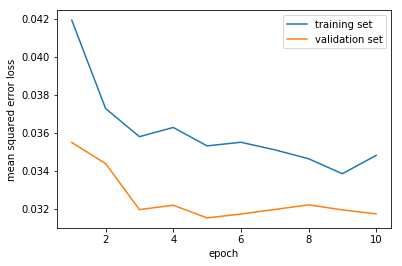

In [5]:
plot_x = np.arange(1, EPOCH+1)
plt.plot(plot_x, fit_generator.history['loss'])
plt.plot(plot_x, fit_generator.history['val_loss'])
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_vs_validation.png')

# save model
model.save('model.h5')